# Neural Network Solutions for the New Keynesian DSGE Model

**Author:** Boston College PhD Student  
**Course:** Empirical Macroeconomics  
**Reference:** Kase, Melosi, & Rottner (2025) - *Estimating Nonlinear Heterogeneous Agent Models with Neural Networks*

---

## Overview

This notebook implements the Neural Network solution method for the simple three-equation New Keynesian Dynamic Stochastic General Equilibrium (DSGE) model. It replicates **Section 3.1: Proof of Concept 1** of Kase, Melosi, & Rottner (2025).

### Scope

This notebook focuses specifically on the **solution** of the model using neural networks. It does not include the particle filter or the likelihood estimation pipeline, which are covered in subsequent parts of the project.

### Key Components

1. **Model Specification**: Three-equation New Keynesian model (IS curve, Phillips curve, Taylor rule)
2. **Neural Network Solution**: Deep learning approximation of policy functions

### Why Neural Networks for DSGE?

Traditional perturbation methods (linearization) fail when models feature:
- Occasionally binding constraints (e.g., zero lower bound)
- Strong nonlinearities
- Heterogeneous agents

Neural networks provide a **global approximation** that handles these challenges effectively.

---

## 1. Mathematical Model

### 1.1 The Three-Equation New Keynesian Model

The canonical NK model consists of three equations:

**IS Curve (Euler Equation):**
$$\hat{X}_t = \mathbb{E}_t[\hat{X}_{t+1}] - \sigma^{-1}\left(\phi_\pi \hat{\pi}_t + \phi_y \hat{X}_t - \mathbb{E}_t[\hat{\pi}_{t+1}] - \zeta_t\right)$$

**New Keynesian Phillips Curve (NKPC):**
$$\hat{\pi}_t = \beta \mathbb{E}_t[\hat{\pi}_{t+1}] + \kappa \hat{X}_t$$

**Exogenous Shock Process (AR(1)):**
$$\zeta_{t+1} = \rho \zeta_t + \varepsilon_{t+1} \cdot \sigma_\varepsilon \cdot \sigma \cdot (\rho - 1) \cdot \omega$$

where $\varepsilon_t \sim \mathcal{N}(0, 1)$.

### 1.2 Parameter Definitions

| Parameter | Description | Typical Range |
|-----------|-------------|---------------|
| $\beta$ | Discount factor | 0.95 - 0.99 |
| $\sigma$ | Relative risk aversion (inverse EIS) | 1.0 - 3.0 |
| $\eta$ | Inverse Frisch elasticity | 0.25 - 2.0 |
| $\phi$ | Calvo parameter (price stickiness) | 0.5 - 0.9 |
| $\phi_\pi$ | Taylor rule: inflation response | 1.25 - 2.5 |
| $\phi_y$ | Taylor rule: output response | 0.0 - 0.5 |
| $\rho$ | Shock persistence | 0.8 - 0.95 |
| $\sigma_\varepsilon$ | Shock standard deviation | 0.02 - 0.1 |

### 1.3 Derived Parameters

**NKPC Slope:**
$$\kappa = \frac{(1 - \phi)(1 - \phi\beta)(\sigma + \eta)}{\phi}$$

**Natural Rate Composite:**
$$\omega = \frac{1 + \eta}{\sigma + \eta}$$

### 1.4 Analytical Solution (Method of Undetermined Coefficients)

For the linear NK model, we can derive closed-form solutions:

$$\text{den} = (\sigma(1 - \rho) + \phi_y)(1 - \beta\rho) + \kappa(\phi_\pi - \rho)$$

$$\hat{X}_t = \frac{1 - \beta\rho}{\text{den}} \cdot \zeta_t$$

$$\hat{\pi}_t = \frac{\kappa}{\text{den}} \cdot \zeta_t$$

These analytical solutions serve as benchmarks for validating our neural network approximations.

---

## 2. Setup and Dependencies

We use Julia's scientific computing ecosystem with Lux.jl for neural networks.

In [29]:
# ============================================================================
# PACKAGE IMPORTS
# ============================================================================
# Scientific computing
using LinearAlgebra      # Matrix operations
using Statistics         # Mean, std, var
using Random            # Random number generation

# Probability distributions
using Distributions     # Uniform, Normal distributions

# Neural networks (Lux.jl ecosystem)
using Lux               # Neural network framework
using Optimisers        # Adam, AdamW optimizers
using Zygote           # Automatic differentiation
using Lux.Training: TrainState, single_train_step!, AutoZygote

# Quasi-random sampling
using Sobol            # Sobol sequences for efficient parameter space exploration

# Utilities
using ProgressMeter    # Progress bars for training loops
using Printf           # Formatted printing
using JLD2             # Save/load Julia objects

# Visualization
using Plots
using Plots.PlotMeasures

# Set random seed for reproducibility
Random.seed!(1234)
println("All packages loaded successfully.")

All packages loaded successfully.


---

## 3. Core Data Structures

We define type-safe structures for model parameters, state variables, and configuration.
Julia's parametric types enable efficient batched computations.

In [30]:
# ============================================================================
# ABSTRACT TYPE HIERARCHY
# ============================================================================
# This enables multiple dispatch - the same function name works for different
# model types (NK, RANK, HANK) with specialized implementations.

"""
    AbstractModelParameters{T}

Abstract base type for all model parameters.
Type parameter T allows for:
- Real: single parameter set (scalar operations)
- Vector{<:Real}: batch of parameter sets (vectorized training)
"""
abstract type AbstractModelParameters{T <: Union{Real, AbstractVector{<:Real}}} end

AbstractModelParameters

In [31]:
# ============================================================================
# NK MODEL PARAMETERS
# ============================================================================

"""
    NKParameters{T} <: AbstractModelParameters{T}

Parameters for the New Keynesian three-equation model.

# Structural Parameters
- β: Discount factor (households' patience)
- σ: Relative risk aversion / inverse of intertemporal elasticity of substitution
- η: Inverse Frisch elasticity of labor supply
- ϕ: Calvo parameter (probability of not adjusting prices)

# Policy Rule Parameters
- ϕ_pi: Taylor rule inflation response (should be > 1 for stability)
- ϕ_y: Taylor rule output gap response

# Shock Process Parameters
- ρ: Persistence of natural rate shock
- σ_shock: Standard deviation of shock innovations

# Derived Parameters (computed by steady_state function)
- κ: Slope of the New Keynesian Phillips Curve
- ω: Composite parameter for natural rate equation
"""
struct NKParameters{T} <: AbstractModelParameters{T}
    β::T
    σ::T
    η::T
    ϕ::T
    ϕ_pi::T
    ϕ_y::T
    ρ::T
    σ_shock::T
    κ::Union{T,Nothing}  # Derived: NKPC slope
    ω::Union{T,Nothing}  # Derived: Natural rate composite
end

# Keyword constructor for clean initialization
function NKParameters(; β, σ, η, ϕ, ϕ_pi, ϕ_y, ρ, σ_shock, κ=nothing, ω=nothing)
    T = typeof(β)
    return NKParameters{T}(β, σ, η, ϕ, ϕ_pi, ϕ_y, ρ, σ_shock, κ, ω)
end

# Positional constructor (useful for creating from arrays)
function NKParameters(β, σ, η, ϕ, ϕ_pi, ϕ_y, ρ, σ_shock, κ=nothing, ω=nothing)
    T = typeof(β)
    return NKParameters{T}(β, σ, η, ϕ, ϕ_pi, ϕ_y, ρ, σ_shock, κ, ω)
end

NKParameters

In [32]:
# ============================================================================
# HELPER FUNCTIONS FOR PARAMETER MANIPULATION
# ============================================================================

"""
    expand(par::NKParameters, batch_size::Int)

Expand scalar parameters to batch by replicating batch_size times.
This enables vectorized operations over multiple economies simultaneously.

Example:
    par = NKParameters(β=0.99, ...)  # Single economy
    par_batch = expand(par, 100)      # 100 identical economies
"""
function expand(par::NKParameters, batch_size::Int)
    return NKParameters{Vector{Float64}}(
        fill(par.β, batch_size),
        fill(par.σ, batch_size),
        fill(par.η, batch_size),
        fill(par.ϕ, batch_size),
        fill(par.ϕ_pi, batch_size),
        fill(par.ϕ_y, batch_size),
        fill(par.ρ, batch_size),
        fill(par.σ_shock, batch_size),
        par.κ === nothing ? nothing : fill(par.κ, batch_size),
        par.ω === nothing ? nothing : fill(par.ω, batch_size)
    )
end

"""
    with_param(par::NKParameters, name::Symbol, val)

Create a new NKParameters struct with one parameter changed.
Useful for sensitivity analysis and likelihood surface computation.

Example:
    par_new = with_param(par, :β, 0.98)  # Change only β
"""
function with_param(par::NKParameters, name::Symbol, val)
    NKParameters(
        β = name == :β ? val : par.β,
        σ = name == :σ ? val : par.σ,
        η = name == :η ? val : par.η,
        ϕ = name == :ϕ ? val : par.ϕ,
        ϕ_pi = name == :ϕ_pi ? val : par.ϕ_pi,
        ϕ_y = name == :ϕ_y ? val : par.ϕ_y,
        ρ = name == :ρ ? val : par.ρ,
        σ_shock = name == :σ_shock ? val : par.σ_shock,
        κ = par.κ,
        ω = par.ω
    )
end

with_param

In [33]:
# ============================================================================
# STATE VARIABLES
# ============================================================================

"""
    State{T}

State variables for the NK model.

In the basic NK model, the only state variable is the natural rate shock ζ.
More complex models (RANK, HANK) would include additional states.

Type T can be:
- Real: single state (scalar)
- Vector{<:Real}: batch of states
- Matrix{<:Real}: MC draws × batch (for expectation computation)
"""
struct State{T<:Union{Real,AbstractArray{<:Real}}}
    ζ::T  # Natural rate shock
end

# Keyword constructor
function State(; ζ)
    return State{typeof(ζ)}(ζ)
end

# Expand scalar state to batch
function expand(state::State, batch_size::Int)
    return State{Vector{Float64}}(fill(state.ζ, batch_size))
end

expand (generic function with 2 methods)

In [34]:
# ============================================================================
# CONFIGURATION STRUCTURES
# ============================================================================

"""
    Ranges

Parameter bounds for training and estimation.
Used for:
1. Input normalization to [-1, 1] for neural network
2. Prior distribution bounds for sampling
3. Parameter space exploration in estimation
"""
Base.@kwdef struct Ranges
    ζ::Tuple{Float64,Float64}        # State variable bounds
    β::Tuple{Float64, Float64}       # Discount factor
    σ::Tuple{Float64, Float64}       # Risk aversion
    η::Tuple{Float64, Float64}       # Inverse Frisch
    ϕ::Tuple{Float64, Float64}       # Calvo parameter
    ϕ_pi::Tuple{Float64, Float64}    # Taylor rule (inflation)
    ϕ_y::Tuple{Float64, Float64}     # Taylor rule (output)
    ρ::Tuple{Float64, Float64}       # Shock persistence
    σ_shock::Tuple{Float64, Float64} # Shock volatility
end

"""
    get_bounds(ranges::Ranges)

Extract lower and upper bounds as vectors for neural network normalization.
"""
function get_bounds(ranges::Ranges)
    fields = fieldnames(typeof(ranges))
    lower = [getfield(ranges, f)[1] for f in fields]
    upper = [getfield(ranges, f)[2] for f in fields]
    return lower, upper
end

"""
    Shocks

Configuration for shock generation.

# Fields
- σ: Standard deviation multiplier for shocks
- antithetic: If true, uses antithetic variates for variance reduction
              (pairs each shock ε with -ε to reduce Monte Carlo variance)
"""
struct Shocks
    σ::Float64
    antithetic::Bool
end

Shocks(; σ, antithetic=false) = Shocks(σ, antithetic)

Shocks

In [35]:
# ============================================================================
# NK MODEL CONTAINER
# ============================================================================

"""
Abstract type for models - enables extension to RANK, HANK, etc.
"""
abstract type AbstractModel{P <: AbstractModelParameters} end

"""
    NKModel{P, N}

Container holding all components of the NK model:
- Economic parameters
- Current state
- Neural network (architecture + trained weights)
- Parameter ranges for normalization

Mutable because network parameters (ps, st) are updated during training.
"""
mutable struct NKModel{P <: AbstractModelParameters, N <: Lux.AbstractLuxLayer} <: AbstractModel{P}
    parameters::P
    state::State
    network::N
    ps::NamedTuple        # Network parameters (weights)
    st::NamedTuple        # Network state (for stateful layers)
    ranges::Ranges
end

# Accessor functions
get_parameters(m::NKModel) = m.parameters
get_state(m::NKModel) = m.state
get_network(m::NKModel) = (m.network, m.ps, m.st)
get_ranges(m::NKModel) = m.ranges

# Mutator functions
set_ps!(m::NKModel, ps) = (m.ps = ps)
set_st!(m::NKModel, st) = (m.st = st)
set_state!(m::NKModel, state) = (m.state = state)

set_state! (generic function with 1 method)

---

## 4. Economic Functions

Core economic computations: steady state, analytical solutions, and state transitions.

In [36]:
# ============================================================================
# STEADY STATE COMPUTATION
# ============================================================================

"""
    steady_state(par::NKParameters)

Compute derived steady-state parameters κ (NKPC slope) and ω (natural rate composite).

Mathematical formulations:
    κ = (1 - ϕ)(1 - ϕβ)(σ + η) / ϕ
    ω = (1 + η) / (σ + η)

These parameters are fundamental to the NK model's dynamics:
- κ determines how responsive inflation is to the output gap
- ω scales the shock process for the natural rate
"""
function steady_state(par::NKParameters)
    # NKPC slope: higher κ means flatter Phillips curve
    κ = ((1 .- par.ϕ) .* (1 .- par.ϕ .* par.β) .* (par.σ .+ par.η)) ./ par.ϕ

    # Natural rate composite parameter
    ω = (1 .+ par.η) ./ (par.σ .+ par.η)

    return NKParameters(
        β=par.β, σ=par.σ, η=par.η, ϕ=par.ϕ,
        ϕ_pi=par.ϕ_pi, ϕ_y=par.ϕ_y, ρ=par.ρ, σ_shock=par.σ_shock,
        κ=κ, ω=ω
    )
end

steady_state

In [37]:
# ============================================================================
# ANALYTICAL POLICY FUNCTIONS
# ============================================================================

"""
    policy_analytical(state::State, par::NKParameters)

Compute analytical policy functions using method of undetermined coefficients.

For the linear NK model, we guess linear decision rules:
    X̂_t = ψ_X · ζ_t
    π̂_t = ψ_π · ζ_t

Substituting into the model equations and solving for ψ_X, ψ_π yields:
    
    den = (σ(1-ρ) + ϕ_y)(1 - βρ) + κ(ϕ_π - ρ)
    
    X̂_t = ((1 - βρ) / den) · ζ_t
    π̂_t = (κ / den) · ζ_t

These closed-form solutions serve as validation benchmarks for the neural network.
"""
function policy_analytical(state::State, par::NKParameters)
    # Compute derived parameters
    κ = ((1 .- par.ϕ) .* (1 .- par.ϕ .* par.β) .* (par.σ .+ par.η)) ./ par.ϕ
    
    # Common denominator from solving the system
    den = (par.σ * (1 - par.ρ) + par.ϕ_y) * (1 - par.β * par.ρ) + κ * (par.ϕ_pi - par.ρ)
    
    # Policy functions: linear in state ζ
    X = ((1 - par.β * par.ρ) / den) .* state.ζ  # Output gap
    π = (κ / den) .* state.ζ                     # Inflation
    
    return X, π
end

policy_analytical

In [38]:
# ============================================================================
# STATE INITIALIZATION AND TRANSITION
# ============================================================================

"""
    initialize_state(par::AbstractModelParameters, batch::Int, ss::AbstractModelParameters)

Initialize state from the ergodic distribution of the AR(1) shock process.

For AR(1): ζ_t = ρ·ζ_{t-1} + ε_t·σ_ε
The ergodic (stationary) distribution is:
    ζ ~ N(0, σ_ergodic²)  where  σ_ergodic = σ_ε / √(1 - ρ²)

This ensures particles start from the model's stationary distribution.
"""
function initialize_state(par::AbstractModelParameters, batch::Int, ss::AbstractModelParameters)
    # Compute shock scaling
    sigma = par.σ_shock .* par.σ .* (par.ρ .- 1) .* ss.ω
    
    # Ergodic standard deviation
    ergodic = sigma ./ sqrt.(1 .- par.ρ .^ 2)
    
    # Draw from ergodic distribution
    ζ = randn(batch) .* ergodic
    
    return State(ζ=ζ)
end

"""
    draw_shocks(shock_struct::Shocks, mc::Int, batch::Int)

Generate shock innovations for Monte Carlo simulation.

If antithetic=true, uses antithetic variates:
    - Draw mc/2 standard normal shocks
    - Pair each ε with -ε
    - This reduces variance while maintaining unbiasedness

Returns: (mc, batch) matrix of shocks
"""
function draw_shocks(shock_struct::Shocks, mc::Int, batch::Int)
    if shock_struct.antithetic
        half_mc = div(mc, 2)
        ϵ_shocks = randn(half_mc, batch)
        shocks = vcat(ϵ_shocks, -ϵ_shocks)  # Antithetic pairs
        if isodd(mc)
            shocks = vcat(shocks, randn(1, batch))  # Handle odd mc
        end
    else
        shocks = randn(mc, batch)
    end
    return shocks
end

# Helper: promote scalar/vector to row matrix for broadcasting
to_row(x::Real) = fill(x, 1, 1)
to_row(x::AbstractVector) = reshape(x, 1, :)
to_row(x::AbstractMatrix) = x

"""
    step(state::State, shocks::AbstractArray, par::NKParameters, ss::NKParameters)

Evolve state forward one period using the AR(1) process:
    ζ_{t+1} = ρ·ζ_t + ε_{t+1}·σ_shock·σ·(ρ-1)·ω

Handles batched operations via broadcasting.
"""
function step(state::State, shocks::AbstractArray, par::NKParameters, ss::NKParameters)
    # AR(1) transition with proper scaling
    new_ζ = to_row(par.ρ) .* to_row(state.ζ) .+
            shocks .* to_row(par.σ_shock) .* to_row(par.σ) .*
            (to_row(par.ρ) .- 1) .* to_row(ss.ω)
    
    return State(ζ=new_ζ)
end

step

In [39]:
# ============================================================================
# PRIOR DISTRIBUTION AND PARAMETER SAMPLING
# ============================================================================

"""
    prior_distribution(ranges::Ranges)

Define uniform prior distributions for all parameters.
Used for training (drawing random parameter combinations) and Bayesian estimation.
"""
function prior_distribution(ranges::Ranges)
    return (
        ζ = Uniform(ranges.ζ[1], ranges.ζ[2]),
        β = Uniform(ranges.β[1], ranges.β[2]),
        σ = Uniform(ranges.σ[1], ranges.σ[2]),
        η = Uniform(ranges.η[1], ranges.η[2]),
        ϕ = Uniform(ranges.ϕ[1], ranges.ϕ[2]),
        ϕ_pi = Uniform(ranges.ϕ_pi[1], ranges.ϕ_pi[2]),
        ϕ_y = Uniform(ranges.ϕ_y[1], ranges.ϕ_y[2]),
        ρ = Uniform(ranges.ρ[1], ranges.ρ[2]),
        σ_shock = Uniform(ranges.σ_shock[1], ranges.σ_shock[2])
    )
end

"""
    draw_parameters(priors, batch_size::Int)

Draw batch_size parameter sets from prior distributions.
Returns NKParameters struct with vector fields (one value per economy in batch).
"""
function draw_parameters(priors, batch_size::Int)
    return NKParameters(
        β = rand(priors.β, batch_size),
        σ = rand(priors.σ, batch_size),
        η = rand(priors.η, batch_size),
        ϕ = rand(priors.ϕ, batch_size),
        ϕ_pi = rand(priors.ϕ_pi, batch_size),
        ϕ_y = rand(priors.ϕ_y, batch_size),
        ρ = rand(priors.ρ, batch_size),
        σ_shock = rand(priors.σ_shock, batch_size)
    )
end

draw_parameters

---

## 5. Neural Network Architecture

The neural network approximates policy functions: given state ζ and parameters θ, output (X, π).

**Architecture:**
- Input: [ζ, β, σ, η, ϕ, ϕ_π, ϕ_y, ρ, σ_ε] (9 dimensions)
- Normalization layer: scales inputs to [-1, 1]
- Hidden layers: 5 layers × 64 neurons with CELU activation
- Output: [X, π] scaled by factor (1/100)

In [40]:
# ============================================================================
# CUSTOM NORMALIZATION LAYER
# ============================================================================

"""
    NormalizeLayer <: Lux.AbstractLuxLayer

Custom Lux layer for min-max normalization to [-1, 1].

Neural networks train better when inputs are normalized.
This layer transforms inputs via:
    normalized = 2 * (x - lb) / (ub - lb) - 1

Benefits:
- Consistent gradient magnitudes across input dimensions
- Faster convergence
- Avoids numerical issues from disparate scales
"""
struct NormalizeLayer <: Lux.AbstractLuxLayer
    lower_bound::Vector{Float32}
    upper_bound::Vector{Float32}
end

# Lux requires these methods for custom layers
Lux.initialparameters(::AbstractRNG, ::NormalizeLayer) = NamedTuple()
Lux.initialstates(::AbstractRNG, ::NormalizeLayer) = NamedTuple()

# Forward pass: normalize inputs
function (layer::NormalizeLayer)(x, ps, st)
    normalized = 2f0 .* (x .- layer.lower_bound) ./ (layer.upper_bound .- layer.lower_bound) .- 1f0
    return normalized, st
end

In [41]:
# ============================================================================
# NEURAL NETWORK FACTORY
# ============================================================================

"""
    make_network(par::AbstractModelParameters, ranges::Ranges; kwargs...)

Create neural network for policy function approximation.

# Architecture
    Input → Normalize → Dense(hidden, activation) × layers → Dense(outputs) → Scale

# Arguments
- par: Model parameters (used to determine input dimensions)
- ranges: Parameter bounds (for normalization layer)
- N_states: Number of state variables (default: 1, just ζ)
- N_outputs: Number of policy outputs (default: 2, X and π)
- hidden: Neurons per hidden layer (default: 64)
- layers: Number of hidden layers (default: 5)
- activation: Activation function (default: CELU - continuously differentiable ELU)
- scale_factor: Output scaling (default: 1/100, keeps outputs in reasonable range)
- include_state: Whether to include state variables in input (default: true)

# Returns
- network: Lux Chain representing the neural network
- ps: Initial network parameters (weights)
- st: Initial network state
"""
function make_network(par::AbstractModelParameters, ranges::Ranges;
    N_states=1, N_outputs=2, hidden=64,
    layers=5, activation=Lux.celu, scale_factor=1 / 100.0, include_state::Bool=true)

    # N_par: number of parameters (excluding κ and ω which are derived)
    N_par = length(fieldnames(typeof(par))) - 2

    if include_state
        N_input = N_states + N_par
        # Extract normalization bounds
        lower, upper = get_bounds(ranges)
        lower = Float32.(lower)
        upper = Float32.(upper)
    else
        N_input = N_par
        lower, upper = get_bounds(ranges)
        lower = Float32.(lower[2:end])  # Exclude state variable bounds
        upper = Float32.(upper[2:end])  # Exclude state variable bounds
    end

    # Normalization layer at input
    norm_layer = NormalizeLayer(lower, upper)

    # Convert to Float32 for network efficiency
    scale_factor = Float32(scale_factor)

    # Build the network
    network = Chain(
        norm_layer,
        Dense(N_input, hidden, activation),
        [Dense(hidden, hidden, activation) for _ in 1:(layers-1)]...,
        Dense(hidden, N_outputs),
        x -> x .* scale_factor  # Scale output
    )

    # Initialize parameters and state
    rng = Random.default_rng()
    ps, st = Lux.setup(rng, network)

    return network, ps, st
end

make_network

In [42]:
# ============================================================================
# NEURAL NETWORK POLICY FUNCTION
# ============================================================================

"""
    policy(network, state::State, par::NKParameters, ps, st)

Evaluate policy functions π(ζ; θ) using the neural network.

# Mathematical Operation
For each state-parameter pair (ζ, θ), compute:
    (X, Π) = f_NN([ζ; θ])

where f_NN is the neural network with weights ps.

# Vectorization Strategy
For MC × Batch computations:
- Input: reshape to (9, mc·B) for single forward pass
- Output: reshape back to (mc, B) for each policy

This is much faster than looping over individual states.

# Returns
- X: Output gap [mc × batch]
- Π: Inflation [mc × batch]  
- st_new: Updated network state
"""
function policy(network, state::State, par::NKParameters, ps, st)
    # Handle ζ dimensions: scalar → (1,1), vector → (1,B), matrix → (mc,B)
    ζ_mat = state.ζ isa Real ? fill(state.ζ, 1, 1) :
            state.ζ isa AbstractVector ? reshape(state.ζ, 1, :) :
            state.ζ
    
    mc, B = size(ζ_mat)  # Monte Carlo draws × batch size
    
    # Flatten ζ for single forward pass: (mc, B) → (1, mc·B)
    ζ_flat = reshape(ζ_mat, 1, mc * B)
    
    # Helper: ensure parameter is array-like for repeat()
    to_vec(x) = x isa AbstractArray ? x : [x]
    
    # Tile parameters to match ζ dimensions
    β_flat = reshape(repeat(to_vec(par.β), inner=mc), 1, mc * B)
    σ_flat = reshape(repeat(to_vec(par.σ), inner=mc), 1, mc * B)
    η_flat = reshape(repeat(to_vec(par.η), inner=mc), 1, mc * B)
    ϕ_flat = reshape(repeat(to_vec(par.ϕ), inner=mc), 1, mc * B)
    ϕ_pi_flat = reshape(repeat(to_vec(par.ϕ_pi), inner=mc), 1, mc * B)
    ϕ_y_flat = reshape(repeat(to_vec(par.ϕ_y), inner=mc), 1, mc * B)
    ρ_flat = reshape(repeat(to_vec(par.ρ), inner=mc), 1, mc * B)
    σ_shock_flat = reshape(repeat(to_vec(par.σ_shock), inner=mc), 1, mc * B)
    
    # Stack input features: (9, mc·B)
    input = vcat(ζ_flat, β_flat, σ_flat, η_flat, ϕ_flat,
                 ϕ_pi_flat, ϕ_y_flat, ρ_flat, σ_shock_flat)
    
    # Convert to Float32 for efficient GPU/network operations
    input = Float32.(input)
    
    # Single forward pass through network
    output, st_new = network(input, ps, st)
    
    # Reshape output: (2, mc·B) → (2, mc, B)
    Y = reshape(output, 2, mc, B)
    
    # Extract policies
    X = Y[1, :, :]  # Output gap
    Π = Y[2, :, :]  # Inflation
    
    return X, Π, st_new
end

policy

---

## 6. Training the Neural Network

Training minimizes the squared Euler equation and Phillips curve residuals:

$$\mathcal{L} = \lambda_X \cdot ||\text{res}_X||^2 + \lambda_\pi \cdot ||\text{res}_\pi||^2$$

where:
- $\text{res}_X$: Euler equation residual
- $\text{res}_\pi$: NKPC residual

In [43]:
# ============================================================================
# RESIDUAL COMPUTATION
# ============================================================================

"""
    residuals(network, ζ::State, par::NKParameters, shocks::AbstractArray,
              ss::NKParameters, ps, st)

Compute residuals of model equilibrium conditions.

# Model Equations

**Euler Equation (IS Curve):**
    X_t = E_t[X_{t+1}] - σ⁻¹(ϕ_π·π_t + ϕ_y·X_t - E_t[π_{t+1}] - ζ_t)

**New Keynesian Phillips Curve:**
    π_t = β·E_t[π_{t+1}] + κ·X_t

# Residual Computation
1. Get current policies: (X_t, π_t) from network
2. Simulate next period state: ζ_{t+1} = ρ·ζ_t + ε
3. Get expected future policies: E[X_{t+1}], E[π_{t+1}] via Monte Carlo
4. Compute residuals by substituting into model equations

# Returns
- res_X_sum: Sum of squared Euler equation residuals
- res_π_sum: Sum of squared NKPC residuals
- st_new: Updated network state
"""
function residuals(network, ζ::State, par::NKParameters, shocks::AbstractArray,
                   ss::NKParameters, ps, st)
    
    # Current period policies
    X_t, π_t, st_new = policy(network, ζ, par, ps, st)
    X = vec(X_t)
    π = vec(π_t)
    
    # Simulate next period state using shock draws
    next_ζ = step(ζ, shocks, par, ss)
    
    # Future policies (for computing expectations)
    X_next, π_next, st_new2 = policy(network, next_ζ, par, ps, st_new)
    
    # Monte Carlo expectations (average over shock draws)
    E_X_next = vec(mean(X_next, dims=1))
    E_π_next = vec(mean(π_next, dims=1))
    
    # Euler equation residual
    res_X = X .- (E_X_next .- (1 ./ par.σ) .* (par.ϕ_pi .* π .+ par.ϕ_y .* X .- E_π_next .- ζ.ζ))
    
    # NKPC residual
    res_π = π .- (par.β .* E_π_next .+ ss.κ .* X)
    
    # Return sum of squared residuals
    return sum(res_X .^ 2), sum(res_π .^ 2), st_new2
end

residuals

In [44]:
# ============================================================================
# LOSS FUNCTION
# ============================================================================

"""
    loss_fn(ps, st, network, par, state, shocks, ss; λ_X=1.0, λ_π=1.0)

Compute weighted loss from equilibrium residuals.

Loss = λ_X · ||res_X||² + λ_π · ||res_π||²

The weights λ_X and λ_π balance the two residual components.
"""
function loss_fn(ps, st, network, par::AbstractModelParameters, state::State,
                 shocks::AbstractArray, ss::AbstractModelParameters;
                 λ_X=1.0, λ_π=1.0)
    
    res_X_sum, res_π_sum, st_new = residuals(network, state, par, shocks, ss, ps, st)
    loss = λ_X * res_X_sum + λ_π * res_π_sum
    
    return loss, res_X_sum, res_π_sum, st_new
end

# Wrapper for Lux.Training API
function loss_fn_wrapper(model, ps, st, data)
    par, state, shocks, ss, weights = data
    loss, res_X_sum, res_π_sum, st_new = loss_fn(ps, st, model, par, state, shocks, ss;
                                                  λ_X=weights.λ_X, λ_π=weights.λ_π)
    return loss, st_new, (res_X=res_X_sum, res_π=res_π_sum)
end

loss_fn_wrapper (generic function with 1 method)

In [45]:
# ============================================================================
# LEARNING RATE SCHEDULE
# ============================================================================

"""
    cosine_annealing_lr(initial_lr, eta_min, epoch, num_epochs)

Cosine annealing learning rate schedule.

Formula:
    lr_t = η_min + (1/2)(lr_0 - η_min)(1 + cos(πt/T))

Benefits:
- Smooth decay from initial_lr to eta_min
- Avoids abrupt learning rate changes
- Often improves final convergence
"""
function cosine_annealing_lr(initial_lr, eta_min, epoch, num_epochs)
    return eta_min + (initial_lr - eta_min) * (1 + cos(π * epoch / num_epochs)) / 2
end

cosine_annealing_lr

In [46]:
# ============================================================================
# MAIN TRAINING FUNCTION
# ============================================================================

"""
    train_simple_internal!(network, ps, st, ranges, shock_config; kwargs...)

Train neural network to approximate policy functions.

# Training Approach (following Kase et al. 2025)
1. Each epoch: draw fresh parameters and states from ergodic distribution
2. Multiple gradient steps per epoch (internal steps)
3. Cosine annealing learning rate schedule

# Why Fresh Samples Each Epoch?
- Ensures training covers the full parameter space
- Avoids overfitting to specific parameter combinations
- Maintains ergodic distribution of states

# Arguments
- network: Lux neural network
- ps, st: Initial network parameters and state
- ranges: Parameter bounds for sampling
- shock_config: Shock configuration

# Keyword Arguments
- num_epochs: Total training epochs (default: 1000)
- batch: Batch size (number of economies, default: 100)
- mc: Monte Carlo draws for expectations (default: 10)
- lr: Initial learning rate (default: 0.001)
- internal: Gradient steps per epoch (default: 5)
- λ_X, λ_π: Loss weights (default: 1.0 each)

# Returns
- train_state: Trained model state (contains optimized weights)
- loss_dict: Training history for diagnostics
"""
function train_simple_internal!(network, ps, st, ranges, shock_config;
    num_epochs=1000, batch=100, mc=10, lr=0.001, internal=5,
    λ_X=1.0, λ_π=1.0, print_every=100, eta_min=1e-10)
    
    # Initialize training state with Adam optimizer
    train_state = Lux.Training.TrainState(network, ps, st, Adam(lr))
    priors = prior_distribution(ranges)
    weights = (λ_X=λ_X, λ_π=λ_π)
    
    # Loss history for diagnostics
    loss_dict = Dict(:iteration => [], :loss => [], :res_X => [], :res_π => [])
    
    # Progress bar
    prog = Progress(num_epochs; dt=1.0, desc="Training... ", showspeed=true)
    
    for epoch in 1:num_epochs
        # Fresh samples each epoch (ensures ergodic distribution)
        par = draw_parameters(priors, batch)
        ss = steady_state(par)
        state = initialize_state(par, batch, ss)
        shocks = draw_shocks(shock_config, mc, batch)
        data = (par, state, shocks, ss, weights)
        
        # Multiple gradient steps per epoch
        loss = nothing
        stats = nothing
        for _ in 1:internal
            _, loss, stats, train_state = Lux.Training.single_train_step!(
                AutoZygote(), loss_fn_wrapper, data, train_state
            )
        end
        
        # Update learning rate (cosine annealing)
        current_lr = cosine_annealing_lr(lr, eta_min, epoch, num_epochs)
        train_state = Lux.Training.TrainState(network, train_state.parameters,
                                               train_state.states, Adam(current_lr))
        
        # Logging
        if epoch % print_every == 0
            println("Epoch $epoch, Loss: $loss, res_X: $(stats.res_X), res_π: $(stats.res_π)")
            push!(loss_dict[:iteration], epoch)
            push!(loss_dict[:loss], loss)
            push!(loss_dict[:res_X], stats.res_X)
            push!(loss_dict[:res_π], stats.res_π)
        end
        
        next!(prog)
    end
    
    return train_state, loss_dict
end

train_simple_internal!

---

## 7. Model Configuration and Training

Set up parameters and train the neural network policy function approximation.

In [47]:
# ============================================================================
# MODEL CONFIGURATION
# ============================================================================

# Baseline parameters (calibrated to quarterly US data)
par = NKParameters(
    β = 0.97,        # Discount factor (implies ~3% annual real rate)
    σ = 2.0,         # Risk aversion (standard value)
    η = 1.125,       # Inverse Frisch (labor supply elasticity ~0.9)
    ϕ = 0.7,         # Calvo (prices adjust ~every 3 quarters on average)
    ϕ_pi = 1.875,    # Taylor rule inflation (satisfies Taylor principle)
    ϕ_y = 0.25,      # Taylor rule output
    ρ = 0.875,       # Shock persistence
    σ_shock = 0.06   # Shock volatility
)

# Parameter ranges for training
ranges = Ranges(
    ζ = (-1.0, 1.0),
    β = (0.95, 0.99),
    σ = (1.0, 3.0),
    η = (0.25, 2.0),
    ϕ = (0.5, 0.9),
    ϕ_pi = (1.25, 2.5),
    ϕ_y = (0.0, 0.5),
    ρ = (0.8, 0.95),
    σ_shock = (0.02, 0.1)
)

# Shock configuration (antithetic variates for variance reduction)
shock_config = Shocks(σ=1.0, antithetic=true)

println("Model configured.")
println("  Baseline β = $(par.β), σ = $(par.σ), ρ = $(par.ρ)")

Model configured.
  Baseline β = 0.97, σ = 2.0, ρ = 0.875


In [48]:
# ============================================================================
# NETWORK CREATION
# ============================================================================

# Network configuration (following Kase et al.)
network_config = (
    N_states = 1,         # Single state variable (ζ)
    N_outputs = 2,        # Two outputs (X, π)
    hidden = 64,          # Neurons per layer
    layers = 5,           # Number of hidden layers
    activation = Lux.celu,  # Continuously differentiable ELU
    scale_factor = 1/100  # Output scaling
)

# Create network
net, ps, st = make_network(par, ranges; network_config...)

println("Neural network created.")
println("  Architecture: $(network_config.hidden) × $(network_config.layers) hidden layers")
println("  Input dim: 9 (1 state + 8 parameters)")
println("  Output dim: 2 (X, π)")

Neural network created.
  Architecture: 64 × 5 hidden layers
  Input dim: 9 (1 state + 8 parameters)
  Output dim: 2 (X, π)


In [49]:
# ============================================================================
# TRAINING OR LOADING PRE-TRAINED MODEL
# ============================================================================
# Set TRAIN_MODEL = true to train from scratch
# Set TRAIN_MODEL = false to load a pre-trained model

TRAIN_MODEL = false  # Set to true to train from scratch

if TRAIN_MODEL
    println("\n" * "="^60)
    println("TRAINING NEURAL NETWORK")
    println("="^60)
    
    # Training configuration
    num_epochs = 5000    # Adjust based on computational budget
    batch_size = 100
    mc_draws = 10
    learning_rate = 0.001
    internal_steps = 5
    
    println("Training: $num_epochs epochs, batch=$batch_size, MC=$mc_draws")
    
    # Train using the network created above
    start_time = time()
    state_result, loss_dict = train_simple_internal!(
        net, ps, st, ranges, shock_config;
        num_epochs=num_epochs,
        batch=batch_size,
        mc=mc_draws,
        lr=learning_rate,
        internal=internal_steps,
        λ_X=1.0,
        λ_π=1.0,
        print_every=500
    )
    elapsed = time() - start_time
    
    # Extract trained parameters
    ps_trained = state_result.parameters
    st_trained = state_result.states
    
    println("\n" * "="^60)
    println("TRAINING COMPLETE")
    println("="^60)
    println(@sprintf("Final loss: %.10f", loss_dict[:loss][end]))
    println(@sprintf("Training time: %.1f minutes", elapsed/60))
    
else
    # =========================================================================
    # LOAD PRE-TRAINED MODEL
    # =========================================================================
    println("Loading pre-trained model...")
    
    # Path to saved model (adjust as needed)
    model_path = "model_simple_internal_100k.jld2"
    
    if isfile(model_path)
        # Load saved data
        data = load(model_path)
        
        # Extract saved components
        ps_loaded = data["parameters"]
        st_loaded = data["states"]
        network_config = data["network_config"]
        ranges_loaded = data["ranges"]
        seed_loaded = data["seed"]
        
        println("✓ Model data loaded from $model_path")
        println("  Network: $(network_config.hidden)×$(network_config.layers)")
        println("  Activation: $(network_config.activation)")
        
        # =====================================================================
        # RECONSTRUCT NETWORK ARCHITECTURE
        # =====================================================================
        # The network architecture must be recreated to match the saved weights
        # This is necessary because Lux networks are not directly serializable
        
        println("\nReconstructing network architecture...")
        
        # Use the loaded ranges for network construction
        ranges = ranges_loaded
        
        # Recreate network with the same configuration as training
        net, _, _ = make_network(par, ranges;
            N_states = network_config.N_states,
            N_outputs = network_config.N_outputs,
            hidden = network_config.hidden,
            layers = network_config.layers,
            activation = network_config.activation,
            scale_factor = network_config.scale_factor
        )
        
        # Use the loaded (trained) parameters
        ps_trained = ps_loaded
        st_trained = st_loaded
        
        println("✓ Network reconstructed with loaded parameters")
        println("  Ready for policy evaluation and visualization")
        
    else
        println("⚠ No saved model found at: $model_path")
        println("  Using untrained network instead.")
        println("  Set TRAIN_MODEL = true to train a new model.")
        ps_trained = ps
        st_trained = st
    end
end

Loading pre-trained model...
✓ Model data loaded from model_simple_internal_100k.jld2
  Network: 64×5
  Activation: celu

Reconstructing network architecture...
✓ Network reconstructed with loaded parameters
  Ready for policy evaluation and visualization


---

## 8. Validation: Neural Network vs Analytical Solution

Compare the neural network policy functions against closed-form analytical solutions.

In [50]:
# ============================================================================
# POINT VALIDATION
# ============================================================================

# Test at -1 standard deviation of ergodic distribution
ss = steady_state(par)
sigma = par.σ_shock * par.σ * (par.ρ - 1) * ss.ω
ergodic_std = sigma / sqrt(1 - par.ρ^2)
test_state = State(ζ = -1.0 * ergodic_std)

# Neural network prediction
X_nn, π_nn, _ = policy(net, test_state, par, ps_trained, st_trained)

# Analytical solution
X_an, π_an = policy_analytical(test_state, par)

println("="^60)
println("MODEL VALIDATION: ζ = -1.0 × σ_ergodic")
println("="^60)
@printf("%-20s %12s %12s %12s\n", "Variable", "NN", "Analytical", "Error %")
println("-"^60)
@printf("%-20s %12.6f %12.6f %12.2f%%\n", "Output gap (X)", X_nn[1], X_an, 100*abs(X_nn[1] - X_an)/abs(X_an))
@printf("%-20s %12.6f %12.6f %12.2f%%\n", "Inflation (π)", π_nn[1], π_an, 100*abs(π_nn[1] - π_an)/abs(π_an))
println("="^60)

MODEL VALIDATION: ζ = -1.0 × σ_ergodic
Variable                       NN   Analytical      Error %
------------------------------------------------------------
Output gap (X)           0.006231     0.006304         1.15%
Inflation (π)            0.017961     0.017917         0.24%


In [51]:
# ============================================================================
# POLICY COMPARISON ACROSS PARAMETER SPACE
# ============================================================================

"""
Compute policy functions over a grid of parameter values.
Compares NN approximation to analytical solution.
"""
function compare_policies(par, ranges, par_name, net, ps, st; n_points=100, shock_std=-1.0)
    # Get parameter range
    param_range = getfield(ranges, par_name)
    param_values = range(param_range[1], param_range[2], length=n_points)
    
    # Storage
    X_analytical = zeros(n_points)
    π_analytical = zeros(n_points)
    X_neural = zeros(n_points)
    π_neural = zeros(n_points)
    
    for (j, param_val) in enumerate(param_values)
        # Create parameter struct with varied parameter
        test_par = with_param(par, par_name, param_val)
        test_ss = steady_state(test_par)
        
        # Compute ergodic std and create test state
        sigma = test_par.σ_shock * test_par.σ * (test_par.ρ - 1) * test_ss.ω
        ergodic = sigma / sqrt(1 - test_par.ρ^2)
        test_state = State(ζ = shock_std * ergodic)
        
        # Analytical
        X_an, π_an = policy_analytical(test_state, test_par)
        X_analytical[j] = X_an
        π_analytical[j] = π_an
        
        # Neural network
        X_nn, π_nn, _ = policy(net, test_state, test_par, ps, st)
        X_neural[j] = X_nn[1]
        π_neural[j] = π_nn[1]
    end
    
    return (values=collect(param_values), X_an=X_analytical, π_an=π_analytical, 
            X_nn=X_neural, π_nn=π_neural)
end

compare_policies

In [52]:
# ============================================================================
# GENERATE COMPARISON PLOTS
# ============================================================================

# Parameters to compare
param_names = [:β, :σ, :η, :ϕ, :ϕ_pi, :ϕ_y, :ρ, :σ_shock]
param_labels = [
    "Discount factor β", "Risk aversion σ", "Inverse Frisch η",
    "Calvo parameter ϕ", "Taylor rule ϕ_π", "Taylor rule ϕ_y",
    "Persistence ρ", "Shock std σ_ε"
]

# Compute comparisons
println("Computing policy comparisons across parameter space...")
results = Dict()
for (i, pname) in enumerate(param_names)
    results[pname] = compare_policies(par, ranges, pname, net, ps_trained, st_trained)
    println("  Completed: $pname")
end
println("Done.")

Computing policy comparisons across parameter space...
  Completed: β
  Completed: σ
  Completed: η
  Completed: ϕ
  Completed: ϕ_pi
  Completed: ϕ_y
  Completed: ρ
  Completed: σ_shock
Done.


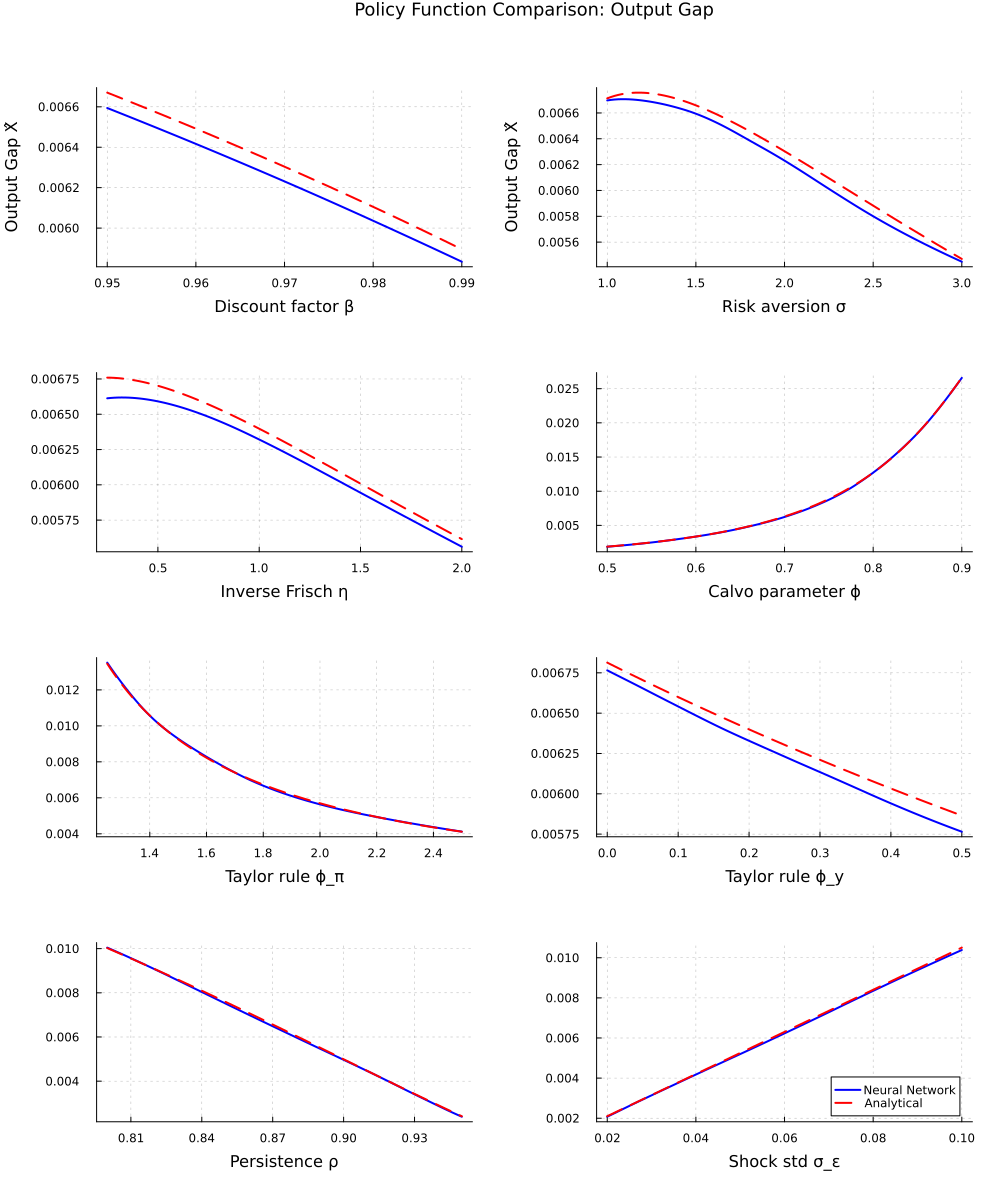

"/Users/macbox/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Boston College PhD/3_Third Semester/01-Empirical Macroeconomics/Hank-NN-Claude/Neural_Network_NK_Model_Submission/Policy Function Comparison-Output Gap.pdf"

In [53]:
# ============================================================================
# PLOT OUTPUT GAP COMPARISON
# ============================================================================

p_output = plot(layout=(4,2), size=(1000, 1200),
    left_margin=5mm, right_margin=5mm, top_margin=5mm, bottom_margin=5mm)

for (i, pname) in enumerate(param_names)
    r = results[pname]
    
    plot!(p_output[i], r.values, r.X_nn,
        label="Neural Network", color=:blue, linewidth=2,
        xlabel=param_labels[i], ylabel=i <= 2 ? "Output Gap X̂" : "",
        legend=(i == 8 ? :bottomright : false),
        grid=true, gridstyle=:dot, gridalpha=0.3)
    
    plot!(p_output[i], r.values, r.X_an,
        label="Analytical", color=:red, linewidth=2, linestyle=:dash)
end

plot!(p_output, plot_title="Policy Function Comparison: Output Gap", plot_titlefontsize=12)
display(p_output)

# Saving the figure as pdf
Plots.savefig(p_output, "Policy Function Comparison-Output Gap.pdf")

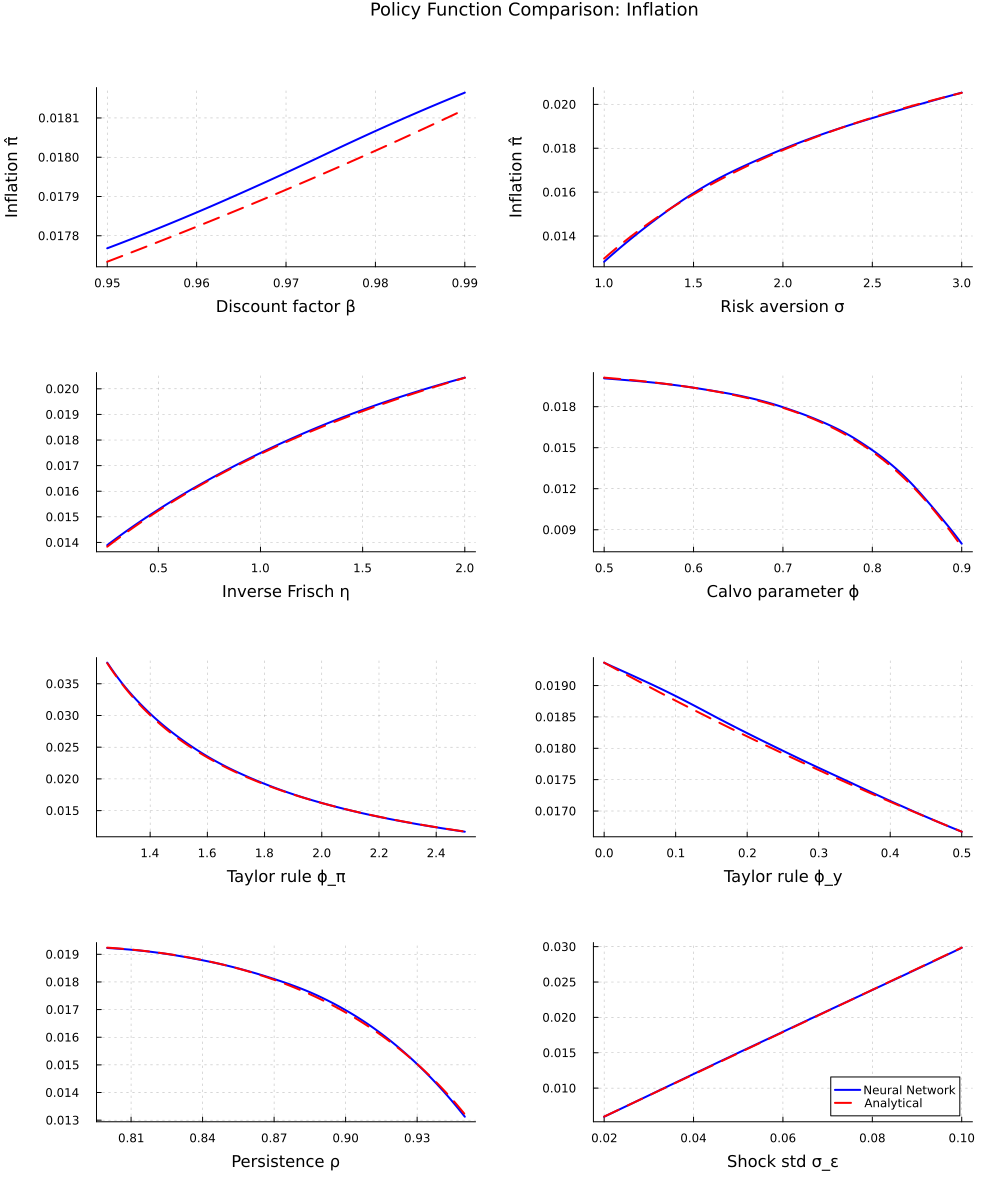

"/Users/macbox/Library/Mobile Documents/3L68KQB4HG~com~readdle~CommonDocuments/Documents/Boston College PhD/3_Third Semester/01-Empirical Macroeconomics/Hank-NN-Claude/Neural_Network_NK_Model_Submission/Policy Function Comparison-Inflation.pdf"

In [54]:
# ============================================================================
# PLOT INFLATION COMPARISON
# ============================================================================

p_inflation = plot(layout=(4,2), size=(1000, 1200),
    left_margin=5mm, right_margin=5mm, top_margin=5mm, bottom_margin=5mm)

for (i, pname) in enumerate(param_names)
    r = results[pname]
    
    plot!(p_inflation[i], r.values, r.π_nn,
        label="Neural Network", color=:blue, linewidth=2,
        xlabel=param_labels[i], ylabel=i <= 2 ? "Inflation π̂" : "",
        legend=(i == 8 ? :bottomright : false),
        grid=true, gridstyle=:dot, gridalpha=0.3)
    
    plot!(p_inflation[i], r.values, r.π_an,
        label="Analytical", color=:red, linewidth=2, linestyle=:dash)
end

plot!(p_inflation, plot_title="Policy Function Comparison: Inflation", plot_titlefontsize=12)
display(p_inflation)

# Saving the figure as pdf
Plots.savefig(p_inflation, "Policy Function Comparison-Inflation.pdf")
